# **1. Install Required Libraries**

In [3]:
!pip install shap lime --quiet

# **2. Import Required Libraries**

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# For the neural network
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For explanations
import shap
from lime import lime_tabular

# **3. Generate Sample Earth Science Dataset**
Generate a synthetic Earth science dataset with cloud cover, temperature, humidity, wind speed, and aerosol concentration as features.

In [5]:
np.random.seed(42)
num_samples = 500

# Create a DataFrame
cloud_cover = np.random.rand(num_samples) * 100  # percentage
temperature = np.random.rand(num_samples) * 40   # degrees Celsius
humidity = np.random.rand(num_samples) * 100     # percentage
wind_speed = np.random.rand(num_samples) * 15    # m/s
aerosol_concentration = np.random.rand(num_samples) * 50  # arbitrary units

# Let's define a target that somewhat depends on these features
# Example: "precipitation intensity" or some atmospheric metric
# We'll just mix them up in a synthetic formula
target = (0.3*cloud_cover + 0.2*temperature + 0.4*humidity +
          0.05*wind_speed + 0.15*aerosol_concentration) + np.random.normal(0, 5, num_samples)

# Create a DataFrame
df = pd.DataFrame({
    'CloudCover': cloud_cover,
    'Temperature': temperature,
    'Humidity': humidity,
    'WindSpeed': wind_speed,
    'AerosolConcentration': aerosol_concentration,
    'Target': target
})

df.to_csv('earth_science_data.csv', index=False)

df.head()

,CloudCover,Temperature,Humidity,WindSpeed,AerosolConcentration,Target
0,37.454012,27.926469,18.513293,7.786227,13.085284,29.184531
1,95.071431,21.443855,54.190095,7.187728,12.348940,59.924043
2,73.199394,12.381105,87.294584,0.384631,45.312729,68.948036
3,59.865848,32.551801,73.222489,5.118717,12.477310,56.334546
4,15.601864,27.389247,80.656115,5.702934,13.597486,43.758932


# **4. Load and Preprocess Dataset**
Load the generated dataset, handle missing values, and scale the features for neural network training.

In [6]:
data = pd.read_csv('earth_science_data.csv')

# data.dropna(inplace=True)  # Remove missing values

# Split features and target
X = data.drop(columns=['Target'])
y = data['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Let's confirm shapes
X_train.shape, X_test.shape

((400, 5), (100, 5))

In [8]:
# Let's confirm shapes
y_train.shape, y_test.shape

((400,), (100,))

# **5. Exploratory Data Analysis**
These plots help visualize correlations, distributions, and pairwise relationships among the features and the target variable.

## 5.1. EDA: Quick look at the dataframe structure

In [9]:
print(data.head())
print(data.info())
print(data.describe())

   CloudCover  Temperature   Humidity  WindSpeed  AerosolConcentration  \
0   37.454012    27.926469  18.513293   7.786227             13.085284   
1   95.071431    21.443855  54.190095   7.187728             12.348940   
2   73.199394    12.381105  87.294584   0.384631             45.312729   
3   59.865848    32.551801  73.222489   5.118717             12.477310   
4   15.601864    27.389247  80.656115   5.702934             13.597486   

      Target  
0  29.184531  
1  59.924043  
2  68.948036  
3  56.334546  
4  43.758932  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CloudCover            500 non-null    float64
 1   Temperature           500 non-null    float64
 2   Humidity              500 non-null    float64
 3   WindSpeed             500 non-null    float64
 4   AerosolConcentration  500 non-null    float64
 5  

## 5.2. EDA: Pairwise Relationships (Pairplot)
This helps visualize how each feature correlates with every other feature and the target.

- `sns.pairplot(data)` creates a grid of scatter plots (for all features vs. each other) and diagonal kernel density plots for each variable.
- Useful for spotting pairwise trends and potential outliers.

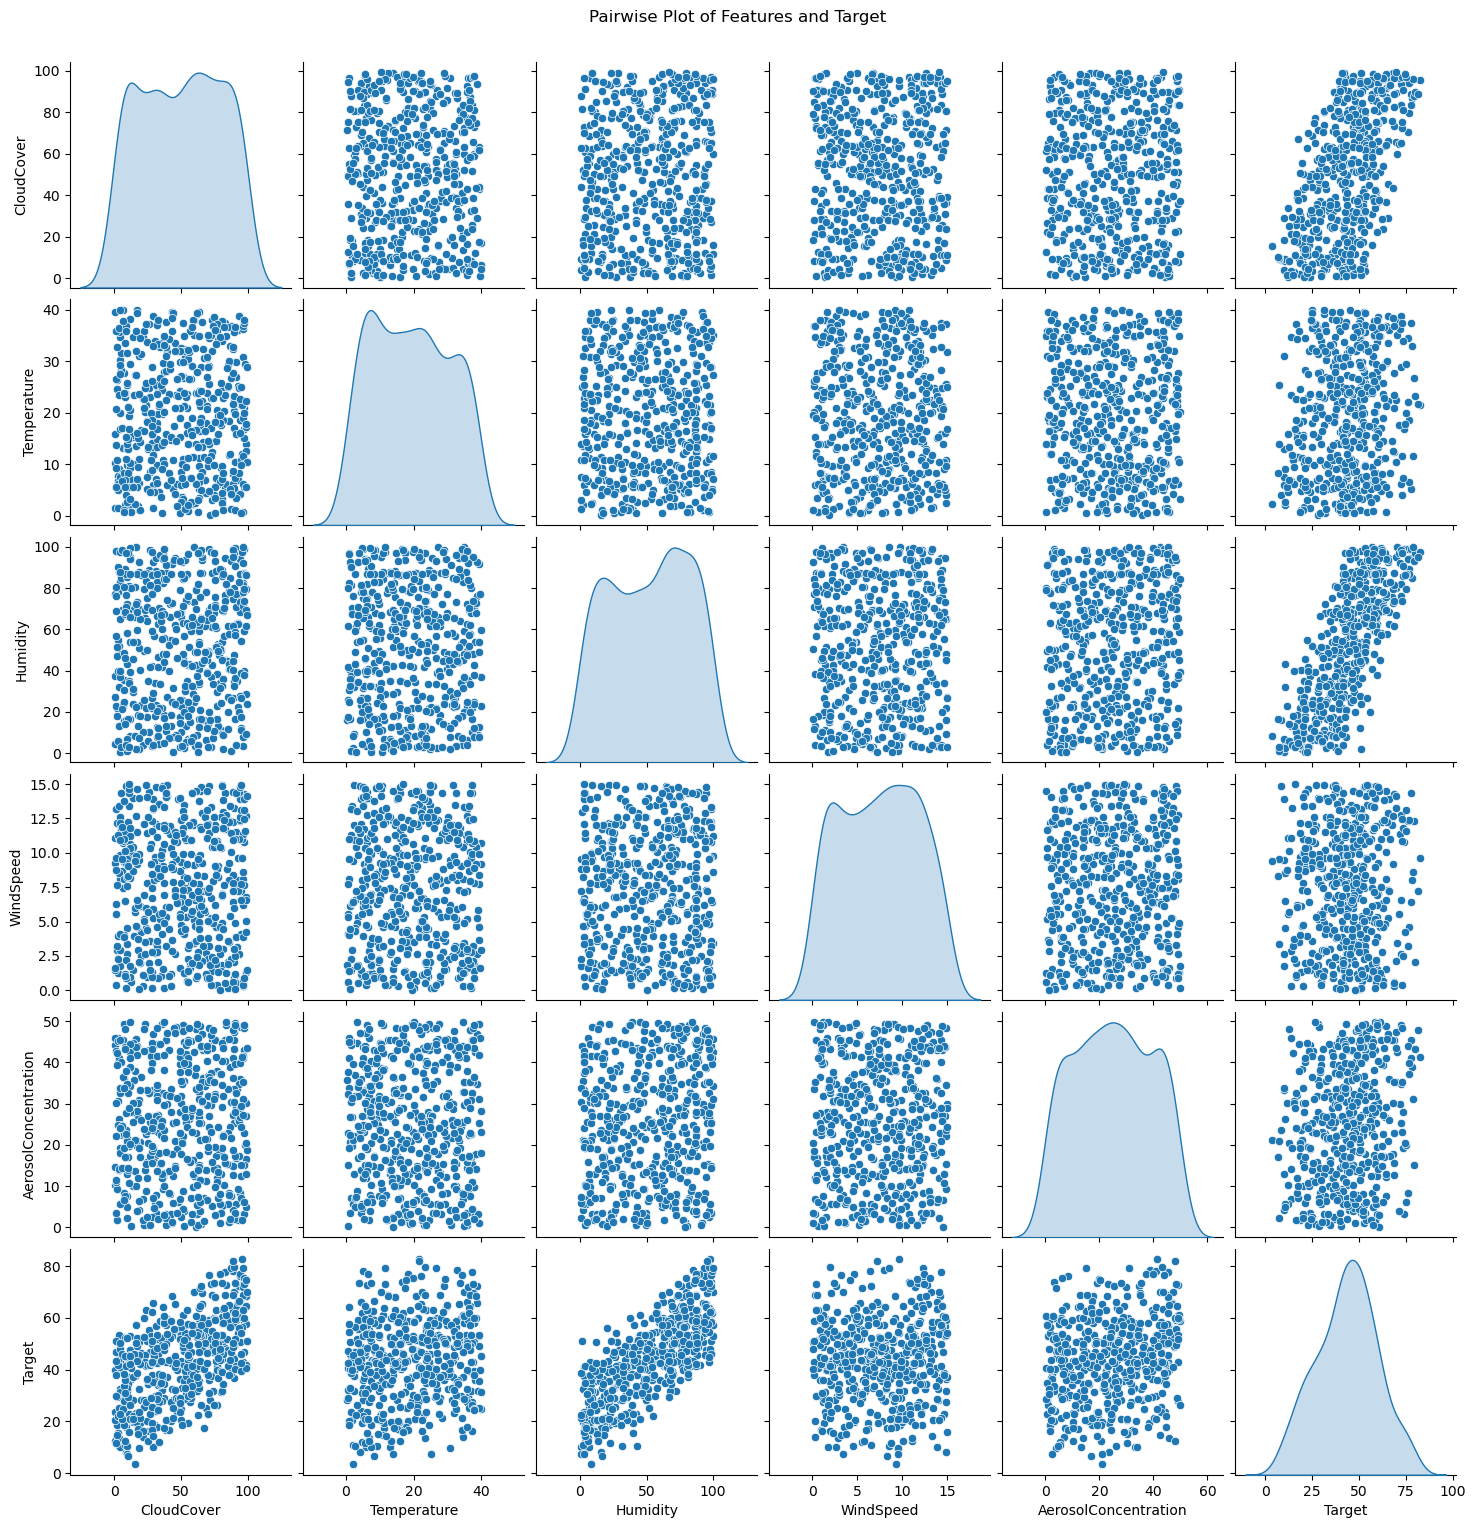

In [12]:
sns.pairplot(data, diag_kind='kde')
plt.suptitle("Pairwise Plot of Features and Target", y=1.02)
plt.show()

## 5.3. EDA: Correlation Heatmap
Displays the correlation coefficients between all pairs of variables, including the target variable.

- `sns.heatmap(corr_matrix, annot=True, ...)` shows correlation values, which measure linear relationships between variables.
- High positive or negative correlations highlight which features might be most predictive of the target.

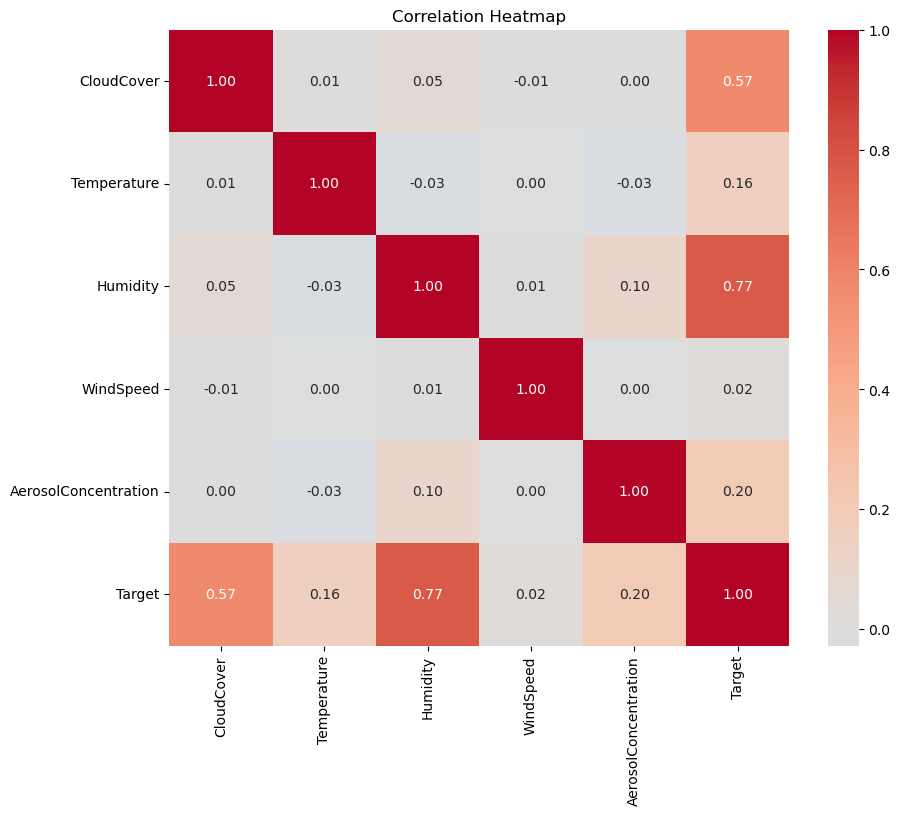

In [13]:
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## 5.4. EDA: Individual Scatter Plots (Optional)
Shows how each feature relates to the target variable in a 2D scatter plot.

- Plot each feature against the target variable to see potential linear or non-linear trends.

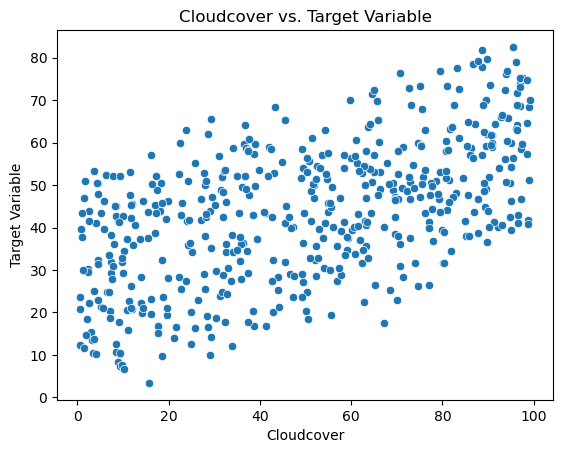

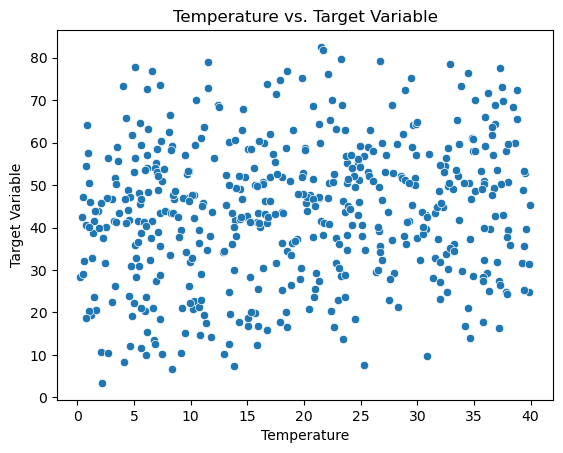

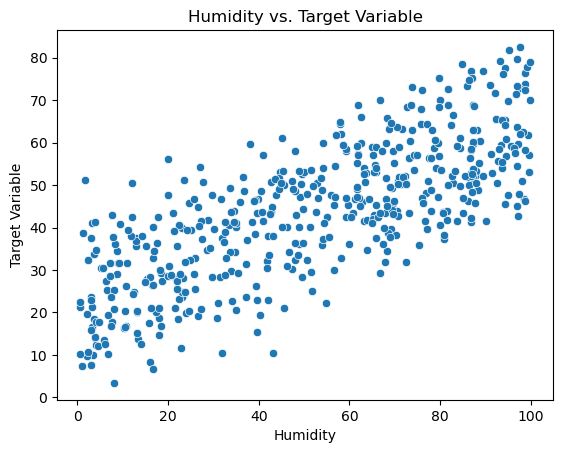

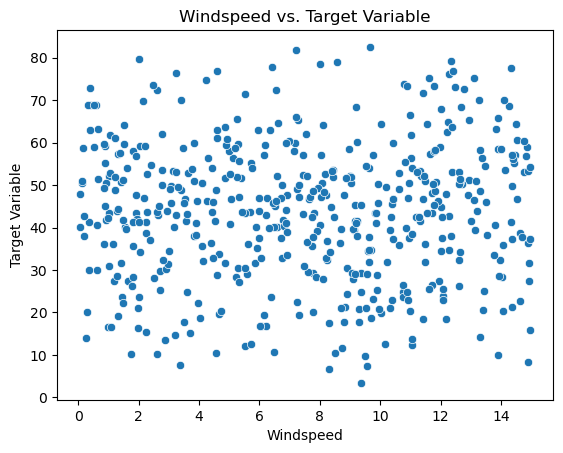

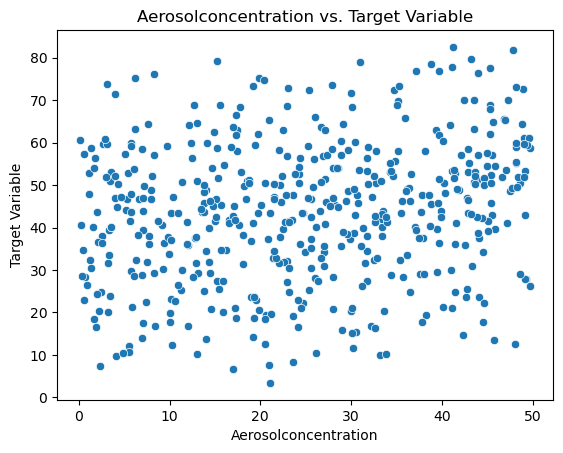

In [14]:
features = ['CloudCover', 'Temperature', 'Humidity', 'WindSpeed', 'AerosolConcentration']
# features = ['temperature', 'humidity', 'wind_speed', 'cloud_cover', 'aerosol_concentration']
for feature in features:
    plt.figure()
    sns.scatterplot(x=data[feature], y=data['Target'])
    plt.title(f"{feature.capitalize()} vs. Target Variable")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Target Variable")
    plt.show()

## 5.5. EDA: Distribution of the Target Variable
Helps see the spread (histogram) and approximate shape (kernel density) of the target distribution.

- A histogram (sns.histplot) helps you understand how the target data is spread out (e.g., is it normally distributed, skewed, bimodal, etc.?).

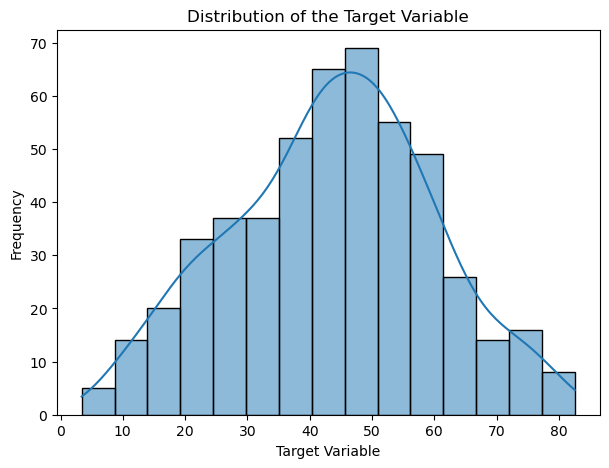

In [15]:
plt.figure(figsize=(7,5))
sns.histplot(data['Target'], kde=True)
plt.title("Distribution of the Target Variable")
plt.xlabel("Target Variable")
plt.ylabel("Frequency")
plt.show()

# **6. Build and Train a Simple Neural Network**
Define a simple feedforward neural network (MLP) using TensorFlow/Keras for regression.


In [10]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# !pip install visualkeras Pillow

In [12]:
# import visualkeras
# visualkeras.layered_view(model, legend=True).show()

In [13]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2138.8235 - mae: 42.8266 - val_loss: 1566.3936 - val_mae: 36.6338
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1288.4987 - mae: 32.1376 - val_loss: 254.6563 - val_mae: 13.3677
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 170.6799 - mae: 10.5774 - val_loss: 68.6113 - val_mae: 6.7886
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 59.2309 - mae: 6.0706 - val_loss: 42.9390 - val_mae: 5.4119
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 44.9490 - mae: 5.2893 - val_loss: 42.0820 - val_mae: 5.3447
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 38.5078 - mae: 4.8929 - val_loss: 40.0210 - val_mae: 5.2159
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.0672 - mae: 5.2368 - val_loss: 36.9353 - val_mae: 4.9517
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.5201 - mae: 4.7978 - val_loss: 35.9994 - val_mae: 4.8632
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 

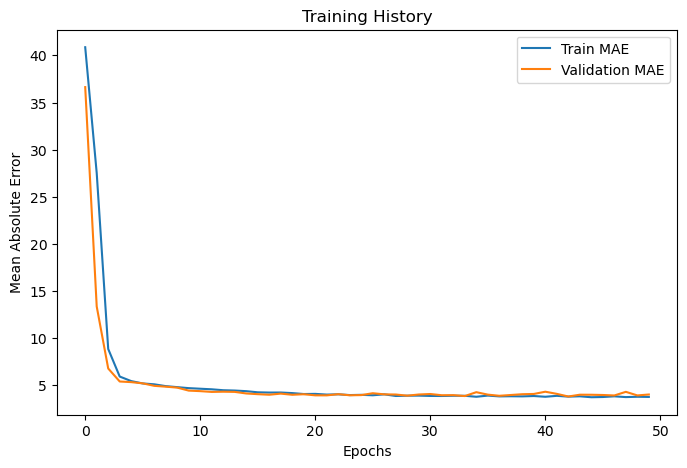

In [14]:
# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training History')
plt.show()

# **7. Explain the Model with SHAP**
Use SHAP to analyze feature importance globally (overall behaviour) and locally.
## 7.1. SHAP on Test Data

In [29]:
# explainer 
explainer = shap.Explainer(model, X_train) # DeepExplainer | KernelExplainer | Explainer
# explainer = Explainer(model, X_train, algorithm="kernel") # 'kernel' | 'tree' | 'deep' 
shap_values = explainer(X_test)

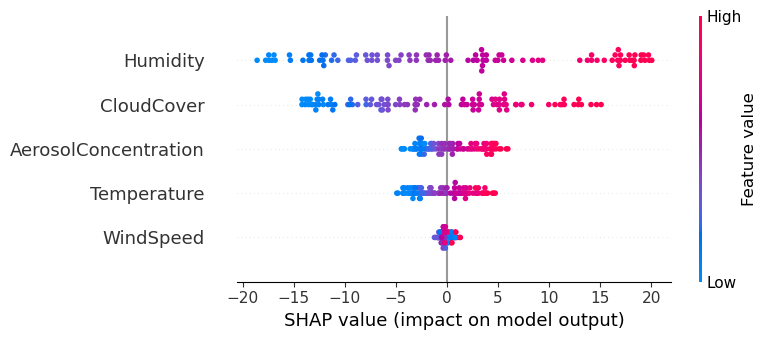

In [16]:
# SHAP Summary Plot (Global Interpretation)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

__Notes__: 
- SHAP values are measured in the same unit as the model’s output.
- If SHAP values range from -5 to +10 for a feature, then each feature can push the prediction down by up to 5 units or increase it by up to 10 units.

__Example__: If we are predicting air quality index (AQI) as the Targer, and AQI (Target) is in the range 0 to 500:
A SHAP value of +20 for humidity means high humidity increases AQI by 20 points.
A SHAP value of -15 for wind speed means strong winds decrease AQI by 15 points.

$$
\begin{align}
&\text{Mathematically, for a given feature } x_i \\\\
&SHAP(x_i) =f(x)-E[f(x)] \\\\
&\text{where} \\\\
&SHAP(x_i) \text{: SHAP value, tells how much } x_i \text{ pushes prediction away from the average} \\
&f(x) \text{: Model's output for instance } x_i\\
&E[f(x)] \text{: Expected (average) model output across the dataset } \\
\end{align}
$$

### 7.1.1. SHAP Dependence Plot for Key Feature: Auto

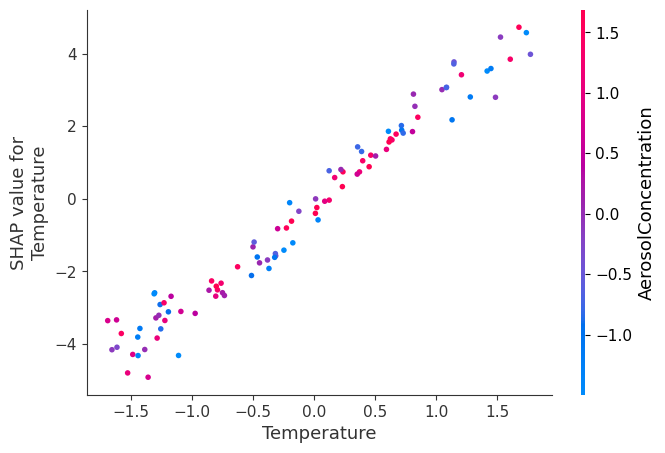

In [26]:
# SHAP Dependence Plot for Key Feature

# Specify Primary Feature
primary_feature_name = "Temperature"

# Auto select Interacting Feature
interacting_feature_name="auto" # Automatically selects strongest interacting feature 

shap.dependence_plot(
    feature_name,
    shap_values.values, 
    X_test, 
    feature_names=X.columns,
    interaction_index=interacting_feature_name
)

### 7.1.2. SHAP Dependence Plot for Key Feature: Manual

How to Choose the Right interaction_index
- If you want SHAP to decide, use "auto".
- If you know a feature interacts strongly, manually set it (e.g., temperature with humidity).
- If you want a specific feature for analysis, pass its name or index.

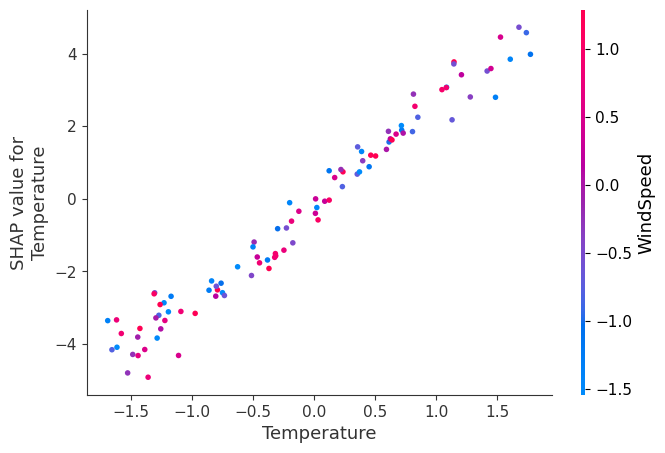

In [28]:
# SHAP Dependence Plot for Key Feature

# Specify Primary Feature
primary_feature_name = "Temperature"

# ALTERNATIVEY, manually select Interacting Feature
interacting_feature_name="WindSpeed" # Manually specify the interaction feature 

shap.dependence_plot(
    feature_name,
    shap_values.values, 
    X_test, 
    feature_names=X.columns,
    interaction_index=interacting_feature_name
)

## 7.2. SHAP on a Subset of Test Data
SHAP: Computationally expensive for large neural networks.

In [24]:
# SUBSET: explainer on a subset (smaller sample)
explainer_subset = shap.Explainer(model, X_train[:50]) # a small sample
shap_values_subset = explainer_subset(X_test[:10])  # explain 10 samples from test

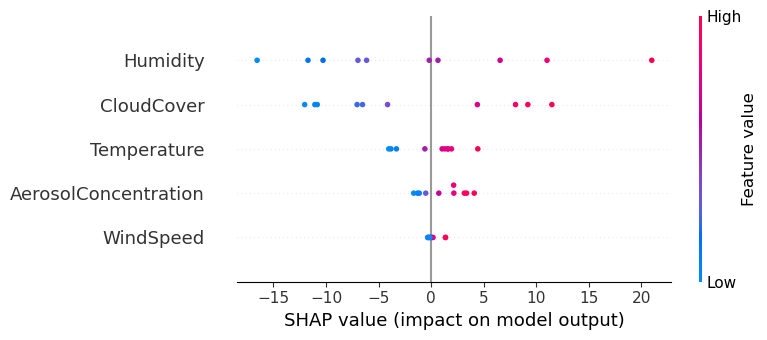

In [25]:
# SUBSET: SHAP Summary Plot 
shap.summary_plot(shap_values_subset, X_test[:10], feature_names=X.columns)

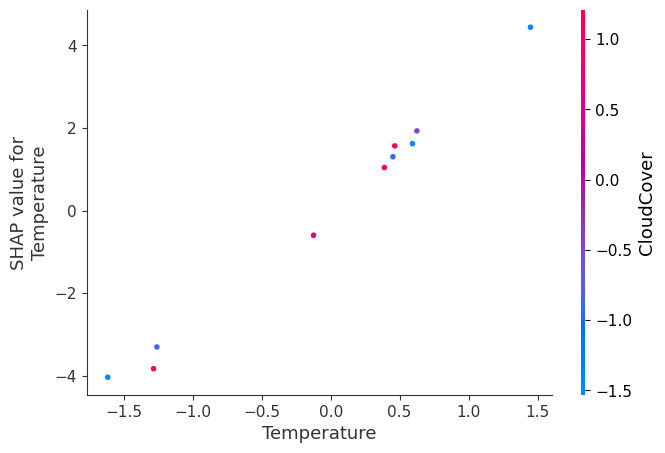

In [26]:
# SUBSET: SHAP Dependence Plot for Key Feature
shap.dependence_plot("Temperature", shap_values_subset.values, X_test[:10], feature_names=X.columns)

# **8. Explain a Single Prediction with LIME**
Use LIME to explain a single prediction.

In [27]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train, 
    feature_names=X.columns, 
    class_names=['Target'], 
    mode='regression'
)

In [31]:
# Select a test instance for explanation
instance_index = 15  # Choose any test sample 0 2 15
sample_instance = X_test[instance_index].reshape(1, -1)  # Reshape for prediction, ensures the instance is in the correct format for prediction.

explanation = explainer.explain_instance(
    data_row=sample_instance.flatten(), 
    predict_fn=model.predict, 
    num_features=5
)
# explanation.show_in_notebook()
explanation.show_in_notebook(show_table=True, show_all=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [29]:
# Print predicted vs. true value
# Get the true value from the dataset
true_value = y_test[instance_index]

# Get the predicted value from the model
predicted_value = model.predict(sample_instance)[0][0]  # Extracts the scalar value using [0][0] since Keras models return predictions as arrays.

print(f"True Value: {true_value:.2f}")
print(f"Predicted Value: {predicted_value:.2f}")

# If there is a big difference between predicted and true values, LIME can help debug why the model is making errors.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True Value: 50.55
Predicted Value: 66.76


In [30]:
# Shows feature contributions (which features increased or decreased the prediction).
explanation.as_list()

[('Humidity > 0.88', 20.476172725401195),
 ('Temperature <= -0.90', -5.382120133913628),
 ('0.05 < CloudCover <= 0.91', 4.204862805366994),
 ('-0.02 < AerosolConcentration <= 0.81', 0.9601841601855683),
 ('0.05 < WindSpeed <= 0.87', -0.2853958265665516)]

# **9. Challenges**
- SHAP is computationally expensive for large datasets and complex models.
- LIME is sensitive to perturbation settings and may not always produce consistent results.
- Combining multiple XAI techniques provides a more reliable interpretation.